# Numba

## Contents

- [Numba](#Numba)  
  - [Overview](#Overview)  
  - [Where are the Bottlenecks?](#Where-are-the-Bottlenecks?)  
  - [Vectorization](#Vectorization)  
  - [Numba](#Numba)  

## Overview

In our lecture on [NumPy](https://lectures.quantecon.org/py/numpy.html) we learned one method to improve speed and efficiency in numerical work

That method, called *vectorization*, involved sending array processing operations in batch to efficient low level code

This clever idea dates back to Matlab, which uses it extensively

Unfortunately, vectorization is limited and has several weaknesses

One weakness is that it is highly memory intensive

Another problem is that only some algorithms can be vectorized

In the last few years, a new Python library called [Numba](http://numba.pydata.org/) has appeared that
solves many of these problems

It does so through something called **just in time (JIT) compilation**

JIT compilation is effective in many numerical settings and can generate extremely fast, efficient code

It can also do other tricks such as facilitate multithreading (a form of parallelization well suited to numerical work)

### The Need for Speed

To understand what Numba does and why, we need some background knowledge

Let’s start by thinking about higher level languages, such as Python

These languages are optimized for humans

This means that the programmer can leave many details to the runtime environment

- specifying variable types  
- memory allocation/deallocation, etc.  


The upside is that, compared to low-level languages, Python is typically faster to write, less error prone and  easier to debug

The downside is that Python is harder to optimize — that is, turn into fast machine code — than languages like C or Fortran

Indeed, the standard implementation of Python (called CPython) cannot match the speed of compiled languages such as C or Fortran

Does that mean that we should just switch to C or Fortran for everything?

The answer is no, no and one hundred times no

High productivity languages should be chosen over high speed languages for the great majority of scientific computing tasks

This is because

1. Of any given program, relatively few lines are ever going to be time-critical  
1. For those lines of code that *are* time-critical, we can achieve C-like speed using a combination of NumPy and Numba  


This lecture provides a guide

## Where are the Bottlenecks?

Let’s start by trying to understand why high level languages like Python are slower than compiled code

### Dynamic Typing


<a id='index-0'></a>
Consider this Python operation

In [1]:
a, b = 10, 10
a + b

20

Even for this simple operation, the Python interpreter has a fair bit of work to do

For example, in the statement a + b, the interpreter has to know which
operation to invoke

If a and b are strings, then a + b requires string concatenation

In [2]:
a, b = 'foo', 'bar'
a + b

'foobar'

If a and b are lists, then a + b requires list concatenation

In [3]:
a, b = ['foo'], ['bar']
a + b

['foo', 'bar']

(We say that the operator `+` is *overloaded* — its action depends on the
type of the objects on which it acts)

As a result, Python must check the type of the objects and then call the correct operation

This involves substantial overheads

#### Static Types


<a id='index-1'></a>
Compiled languages avoid these overheads with explicit, static types

For example, consider the following C code, which sums the integers from 1 to 10

```c
#include <stdio.h>

int main(void) {
    int i;
    int sum = 0;
    for (i = 1; i <= 10; i++) {
        sum = sum + i;
    }
    printf("sum = %d\n", sum);
    return 0;
}
```


The variables `i` and `sum` are explicitly declared to be integers

Hence, the meaning of addition here is completely unambiguous

### Data Access

Another drag on speed for high level languages is data access

To illustrate, let’s consider the problem of summing some data — say, a collection of integers

#### Summing with Compiled Code

In C or Fortran, these integers would typically be stored in an array, which
is a simple data structure for storing homogeneous data

Such an array is stored in a single contiguous block of memory

- In modern computers, memory addresses are allocated to each byte (one byte = 8 bits)  
- For example, a 64 bit integer is stored in 8 bytes of memory  
- An array of $ n $ such integers occupies $ 8n $ **consecutive** memory slots  


Moreover, the compiler is made aware of the data type by the programmer

- In this case 64 bit integers  


Hence, each successive data point can be accessed by shifting forward in memory
space by a known and fixed amount

- In this case 8 bytes  

#### Summing in Pure Python

Python tries to replicate these ideas to some degree

For example, in the standard Python implementation (CPython), list elements are placed in memory locations that are in a sense contiguous

However, these list elements are more like pointers to data rather than actual data

Hence, there is still overhead involved in accessing the data values themselves

This is a considerable drag on speed

In fact, it’s generally true that memory traffic is a major culprit when it comes to slow execution

Let’s look at some ways around these problems

## Vectorization


<a id='index-3'></a>
Vectorization is about sending batches of related operations to native machine code

- The machine code itself is typically compiled from carefully optimized C or Fortran  


This can greatly accelerate many (but not all) numerical computations

### Operations on Arrays


<a id='index-4'></a>
First let’s run some imports

In [4]:
import random
import numpy as np
import quantecon as qe

Now let’s try this non-vectorized code

In [5]:
qe.util.tic()   # Start timing
n = 100_000
sum = 0
for i in range(n):
    x = random.uniform(0, 1)
    sum += x**2
qe.util.toc()   # End timing

TOC: Elapsed: 0:00:0.04


0.04614853858947754

Now compare this vectorized code

In [6]:
qe.util.tic()
n = 100_000
x = np.random.uniform(0, 1, n)
np.sum(x**2)
qe.util.toc()

TOC: Elapsed: 0:00:0.03


0.031944990158081055

The second code block — which achieves the same thing as the first — runs
much faster

The reason is that in the second implementation we have broken the loop down into three basic operations

1. draw n uniforms  
1. square them  
1. sum them  


These are sent as batch operators to optimized machine code

Apart from minor overheads associated with sending data back and forth, the result is C or Fortran-like speed

When we run batch operations on arrays like this, we say that the code is *vectorized*

Vectorized code is typically fast and efficient

It is also surprisingly flexible, in the sense that many operations can be vectorized

The next section illustrates this point


<a id='ufuncs'></a>

### Universal Functions


<a id='index-5'></a>
Many functions provided by NumPy are so-called *universal functions* — also called [ufuncs](https://docs.scipy.org/doc/numpy/reference/ufuncs.html)

This means that they

- map scalars into scalars, as expected  
- map arrays into arrays, acting element-wise  


For example, `np.cos` is a ufunc:

In [7]:
np.cos(1.0)

0.5403023058681398

In [8]:
np.cos(np.linspace(0, 1, 3))

array([1.        , 0.87758256, 0.54030231])

By exploiting ufuncs, many operations can be vectorized

For example, consider the problem of maximizing a function $ f $ of two
variables $ (x,y) $ over the square $ [-a, a] \times [-a, a] $

For $ f $ and $ a $ let’s choose

$$
f(x,y) = \frac{\cos(x^2 + y^2)}{1 + x^2 + y^2}
\quad \text{and} \quad
a = 3
$$

Here’s a plot of $ f $

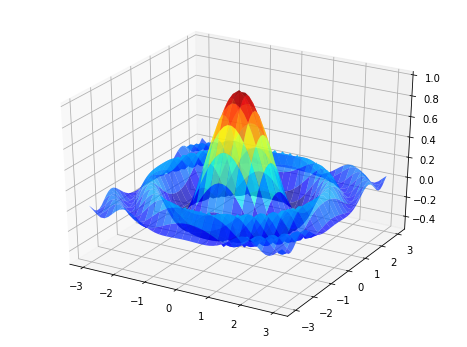

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

xgrid = np.linspace(-3, 3, 50)
ygrid = xgrid
x, y = np.meshgrid(xgrid, ygrid)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                f(x, y),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.7,
                linewidth=0.25)
ax.set_zlim(-0.5, 1.0)
plt.show()

To maximize it, we’re going to use a naive grid search:

1. Evaluate $ f $ for all $ (x,y) $ in a grid on the square  
1. Return the maximum of observed values  


Here’s a non-vectorized version that uses Python loops

In [10]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 1000)
m = -np.inf

qe.tic()
for x in grid:
    for y in grid:
        z = f(x, y)
        if z > m:
            m = z

qe.toc()

TOC: Elapsed: 0:00:2.98


2.9816253185272217

And here’s a vectorized version

In [11]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)

qe.tic()
np.max(f(x, y))
qe.toc()

TOC: Elapsed: 0:00:0.00


0.009057998657226562

In the vectorized version, all the looping takes place in compiled code

As you can see, the second version is **much** faster

(We’ll make it even faster again below, when we discuss Numba)


<a id='numba-p-c-vectorization'></a>

### Pros and Cons of Vectorization

At its best, vectorization yields fast, simple code

However, it’s not without disadvantages

One issue is that it can be highly memory intensive

For example, the vectorized maximization routine above is far more memory
intensive than the non-vectorized version that preceded it

Another issue is that not all algorithms can be vectorized

In these kinds of settings, we need to go back to loops

Fortunately, there are nice ways to speed up Python loops


<a id='numba-link'></a>

## Numba


<a id='index-7'></a>
One exciting development in this direction is [Numba](http://numba.pydata.org/)

Numba aims to automatically compile functions to native machine code instructions on the fly

The process isn’t flawless, since Numba needs to infer type information on all variables to generate pure machine instructions

Such inference isn’t possible in every setting

But for simple routines Numba infers types very well

Moreover, the “hot loops” at the heart of our code that we need to speed up are often such simple routines

### Prerequisites

If you [followed our set up instructions](https://lectures.quantecon.org/py/getting_started.html), then Numba should be installed

Make sure you have the latest version of Anaconda by running `conda update anaconda` from a terminal (Mac, Linux) / Anaconda command prompt (Windows)


<a id='quad-map-eg'></a>

### An Example

Let’s consider some problems that are difficult to vectorize

One is generating the trajectory of a difference equation given an initial
condition

Let’s take the difference equation to be the quadratic map

$$
x_{t+1} = 4 x_t (1 - x_t)
$$

Here’s the plot of a typical trajectory, starting from $ x_0 = 0.1 $, with $ t $ on the x-axis

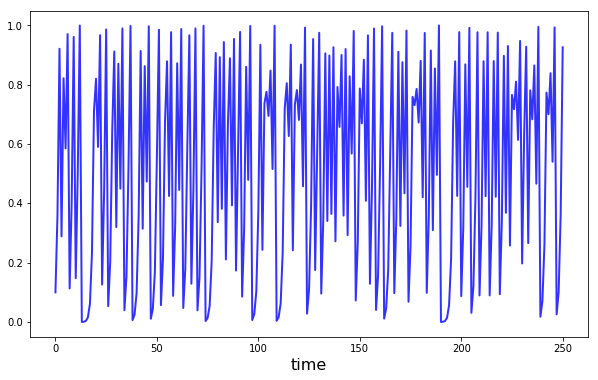

In [12]:
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x

x = qm(0.1, 250)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, 'b-', lw=2, alpha=0.8)
ax.set_xlabel('time', fontsize=16)
plt.show()

To speed this up using Numba is trivial using Numba’s `jit` function

In [13]:
from numba import jit

qm_numba = jit(qm)  # qm_numba is now a 'compiled' version of qm

Let’s time and compare identical function calls across these two versions:

In [14]:
qe.util.tic()
qm(0.1, int(10**5))
time1 = qe.util.toc()

TOC: Elapsed: 0:00:0.07


In [15]:
qe.util.tic()
qm_numba(0.1, int(10**5))
time2 = qe.util.toc()

TOC: Elapsed: 0:00:0.06


The first execution is relatively slow because of JIT compilation (see below)

Next time and all subsequent times it runs much faster:


<a id='qm-numba-result'></a>

In [16]:
qe.util.tic()
qm_numba(0.1, int(10**5))
time2 = qe.util.toc()

TOC: Elapsed: 0:00:0.00


In [17]:
time1 / time2  # Calculate speed gain

197.04381443298968

That’s a speed increase of two orders of magnitude!

Your mileage will of course vary depending on hardware and so on

Nonetheless, two orders of magnitude is huge relative to how simple and clear the implementation is

#### Decorator Notation

If you don’t need a separate name for the “numbafied” version of `qm`,
you can just put `@jit` before the function

In [18]:
@jit
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x

This is equivalent to `qm = jit(qm)`

### How and When it Works

Numba attempts to generate fast machine code using the infrastructure provided by the [LLVM Project](http://llvm.org/)

It does this by inferring type information on the fly

As you can imagine, this is easier for simple Python objects (simple scalar data types, such as floats, integers, etc.)

Numba also plays well with NumPy arrays, which it treats as typed memory regions

In an ideal setting, Numba can infer all necessary type information

This allows it to generate native machine code, without having to call the Python runtime environment

In such a setting, Numba will be on par with machine code from low level languages

When Numba cannot infer all type information, some Python objects are given generic `object` status, and some code is generated using the Python runtime

In this second setting, Numba typically provides only minor speed gains — or none at all

Hence, it’s prudent when using Numba to focus on speeding up small, time-critical snippets of code

This will give you much better performance than blanketing your Python programs with `@jit` statements

#### A Gotcha: Global Variables

Consider the following example

In [19]:
a = 1

@jit
def add_x(x):
    return a + x

print(add_x(10))

11


In [20]:
a = 2

print(add_x(10))

11


Notice that changing the global had no effect on the value returned by the
function

When Numba compiles machine code for functions, it treats global variables as constants to ensure type stability

### Numba for vectorization

Numba can also be used to create custom [ufuncs](#ufuncs) with the [@vectorize](http://numba.pydata.org/numba-doc/dev/user/vectorize.html) decorator

To illustrate the advantage of using Numba to vectorize a function, we
return to a maximization problem [discussed above](#ufuncs)

In [21]:
from numba import vectorize

@vectorize
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)

np.max(f_vec(x, y))  # Run once to compile

qe.tic()
np.max(f_vec(x, y))
qe.toc()

TOC: Elapsed: 0:00:0.02


0.02804732322692871

This is faster than our vectorized version using NumPy’s ufuncs

Why should that be?  After all, anything vectorized with NumPy will be running in fast C or Fortran code

The reason is that it’s much less memory intensive

For example, when NumPy computes np.cos(x**2 + y**2) it first creates the
intermediate arrays x**2 and y**2, then it creates the array np.cos(x**2 + y**2)

In our @vectorize version using Numba, the entire operator is reduced to a
single vectorized process and none of these intermediate arrays are created

We can gain further speed improvements using Numba’s automatic parallelization
feature by specifying target=’parallel’

In this case, we need to specify the types of our inputs and outputs

In [22]:
@vectorize('float64(float64, float64)', target='parallel')
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

np.max(f_vec(x, y))  # Run once to compile

qe.tic()
np.max(f_vec(x, y))
qe.toc()

TOC: Elapsed: 0:00:0.00


0.002671957015991211

This is a striking speed up with very little effort